In [97]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy
from scipy.stats import rankdata
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Define the model
class Net(nn.Module):
  def __init__(self, in_features):
    super().__init__()

    layer1_size = round(in_features - (in_features/3))
    layer2_size = round(in_features - ((2/3)*in_features))
    ##feedfoward layers:
    self.ff1 = nn.Linear(in_features, layer1_size) # input dimension is 2, first hidden layer is 10
    self.ff2 = nn.Linear(layer1_size, layer2_size) # second hidden layer is 2
    self.ff_out = nn.Linear(layer2_size, 1)  # output layer is 1

    ##activation:
    # self.act = nn.Sigmoid()
    self.act = nn.ReLU()

    if torch.cuda.is_available():
      self.cuda()


  def forward(self, input_data):
    input_data = torch.as_tensor(input_data, dtype=torch.float)
    out = self.act(self.ff1(input_data))
    out = self.act(self.ff2(out))
    out = self.ff_out(out)
    return out #returns classification for each image


  def xavier_weights(self):
    nn.init.xavier_uniform_(self.ff1.weight)
    nn.init.xavier_uniform_(self.ff2.weight)
    nn.init.xavier_uniform_(self.ff_out.weight)

### Train the model:

In [3]:
def calc_err(y_pred, y_test):
  y_test = y_test.detach().numpy()
  y_pred = y_pred.detach().numpy()
  err = mean_squared_error(y_test, y_pred)

  # print("calc_err, y_test: ", y_test)
  # print("calc_err, y_pred: ", y_pred)
  # print("calc_err, err: ", err)

  return err

# Function to plot data for a certain seed
def plot_loss_acc(plot_data, index):
  plt.figure(index)
  ax = plt.gca()

  # change plot_data into a np array
  data = np.array(plot_data)
  x = data[:,0]           # first column is the epoch count
  train_loss = data[:,1]  # second column is train loss
  train_acc = data[:,2]   # 3rd column is train accuracy
  test_acc = data[:,3]    # 4th column is test accuracy

  ax.plot(train_loss, label = 'Train Loss')
  ax.plot(test_acc, label = 'Test Error')
  ax.legend()
  # ax.set_ylim([0.0, 1.0])
  plt.xlabel('Epochs')
  plt.title('Train Loss and Test Error for Seed %d' %index)

# function for training model
def train_model(model, train_loader, test_loader, epochs=300, seed=3):

  # keep output fixed
  torch.manual_seed(seed)
  random.seed(seed)

  # reset parameters
  model.xavier_weights()

  plot_data = []

  for epoch in range(epochs):
    # debug
    print(epoch)

    tot_train_loss = 0
    tot_train_err = 0
    tot_test_err = 0

    batch_num = 0

    # calculate training loss and acc
    for x_train, y_train in train_loader:
      # print(x_train.shape)
      # print(y_train.shape)
      # batch_num = batch_num + 1
      # print("batch num: ", batch_num)

      x_train, y_train = x_train.to(device), y_train.to(device)

      optimizer.zero_grad()

      yhat = model(x_train)
      loss = loss_metric(yhat, y_train)

      # debug
      # print("yhat: ", yhat, ". yhat type: ", type(yhat))
      # print("y_train: ", y_train, ". y_train type: ", type(yhat))

      epoch_train_err = calc_err(yhat,y_train)
      loss.backward()
      optimizer.step()

      tot_train_loss += loss.item()
      tot_train_err += epoch_train_err.item()

    test_y_pred = []
    test_y_truth = []

    # calculate testing loss and acc
    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        yhat = model(x_test)

        epoch_test_err = calc_err(yhat, y_test)

        tot_test_err += epoch_test_err

        test_y_pred = yhat
        test_y_truth = y_test

        # debug
        # print("current total test error: ", tot_test_err)

    plot_data.append([epoch, tot_train_loss/len(train_loader), tot_train_err/len(train_loader), tot_test_err/len(test_loader)])
    print(f'Epoch {epoch+0:03}: | Loss: {tot_train_loss/len(train_loader):.5f} | TrainErr: {tot_train_err/len(train_loader):.3f} | TestErr: {tot_test_err/len(test_loader):.3f}')

  return plot_data, test_y_pred, test_y_truth

In [4]:
# Cokie's google drive paths:
data_base_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/'
rnaseq_filtered_data_path = data_base_path + 'RNAseqRawBatchCorrectedFiltered.tsv'
rnaseq_metadata_path = data_base_path + 'RNAseqMetaData.tsv'
abtiter_normalized_path = data_base_path + 'AbtiterNormalizedData.tsv'
abtiter_metadata_path = data_base_path + 'AbtiterMetadata.tsv'
cellfreq_normalized_path = data_base_path + 'CytofBatchCorrectedData.tsv'
cellfreq_metadata_path = data_base_path + 'CytofMetadata.tsv'
cytokine_normalized_path = data_base_path + 'CytokineBatchCorrectedData.tsv'
cytokine_metadata_path = data_base_path + 'CytokineMetadata.tsv'

rnaseq_filtered_data_raw = pd.read_csv(rnaseq_filtered_data_path, sep='\t')
rnaseq_metadata = pd.read_csv(rnaseq_metadata_path, sep='\t')
abtiter_normalized_data_raw = pd.read_csv(abtiter_normalized_path, sep='\t')
abtiter_metadata = pd.read_csv(abtiter_metadata_path, sep='\t')
cellfreq_normalized_data_raw = pd.read_csv(cellfreq_normalized_path, sep='\t')
cellfreq_metadata = pd.read_csv(cellfreq_metadata_path, sep='\t')
cytokine_normalized_data_raw = pd.read_csv(cytokine_normalized_path, sep='\t')
cytokine_metadata = pd.read_csv(cytokine_metadata_path, sep='\t')

In [5]:
## load data for abtiters
abtiter_metadata_subset = abtiter_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
abtiter_data_transposed = abtiter_normalized_data_raw.T
abtiter_data_transposed.index.name = 'specimen_id'
abtiter_data_transposed.reset_index(inplace=True)
abtiter_data_transposed['specimen_id'] = pd.to_numeric(abtiter_data_transposed['specimen_id'])
abtiter_data_merged = abtiter_data_transposed.merge(abtiter_metadata_subset, how='left', on='specimen_id')
abtiter_data_merged_subsetted = abtiter_data_merged[abtiter_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All abtiter data points (input and output), should be 180 long: ", abtiter_data_merged_subsetted.shape)

## load data for cell frequency
cellfreq_metadata_subset = cellfreq_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
cellfreq_data_transposed = cellfreq_normalized_data_raw.T
cellfreq_data_transposed.index.name = 'specimen_id'
cellfreq_data_transposed.reset_index(inplace=True)
cellfreq_data_transposed['specimen_id'] = pd.to_numeric(cellfreq_data_transposed['specimen_id'])
cellfreq_data_merged = cellfreq_data_transposed.merge(cellfreq_metadata_subset, how='left', on='specimen_id')
cellfreq_data_merged_subsetted = cellfreq_data_merged[cellfreq_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All cell freq data points (input and output), should be 106 long: ", cellfreq_data_merged_subsetted.shape)

## load data for cytokine concentrations
cytokine_metadata_subset = cytokine_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
cytokine_data_transposed = cytokine_normalized_data_raw.T
cytokine_data_transposed.index.name = 'specimen_id'
cytokine_data_transposed.reset_index(inplace=True)
cytokine_data_transposed['specimen_id'] = pd.to_numeric(cytokine_data_transposed['specimen_id'])
cytokine_data_merged = cytokine_data_transposed.merge(cytokine_metadata_subset, how='left', on='specimen_id')
cytokine_data_merged_subsetted = cytokine_data_merged[cytokine_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All cytokine data points (input and output), should be 108 long: ", cytokine_data_merged_subsetted.shape)

All abtiter data points (input and output), should be 180 long:  (181, 30)
All cell freq data points (input and output), should be 106 long:  (106, 23)
All cytokine data points (input and output), should be 108 long:  (108, 33)


In [34]:
# combine the data types, then impute any values that are missing for
# cell freq, cytokines, abtiters
all_titerPred_data = pd.merge(abtiter_data_transposed, cellfreq_data_transposed, how='left', on='specimen_id')
all_titerPred_data = pd.merge(all_titerPred_data, cytokine_data_transposed, how='left', on='specimen_id')
all_titerPred_data['specimen_id'] = pd.to_numeric(abtiter_data_transposed['specimen_id'])
all_titerPred_merged_metadata = all_titerPred_data.merge(abtiter_metadata_subset, how='left', on='specimen_id')
all_titerPred_time_subset = all_titerPred_merged_metadata[all_titerPred_merged_metadata['planned_day_relative_to_boost'].isin([0, 14])]

# make sure data only has complete sets of timepoint 0 and 14 for each subject
subject_dict = {}
for index, row in all_titerPred_time_subset.iterrows():
  if row['subject_id'] in subject_dict:
    subject_dict[row['subject_id']] = subject_dict[row['subject_id']] + 1
  else:
    subject_dict[row['subject_id']] = 1

completeSubjects = []
for elem in subject_dict:
  if subject_dict[elem] == 2:
    completeSubjects.append(elem)

all_titerPred_mask = all_titerPred_time_subset['subject_id'].isin(completeSubjects)
all_titerPred_complete = all_titerPred_time_subset[all_titerPred_mask]

# split data into input (x), and output (y, label)
combined_toImpute_titerPred = all_titerPred_complete.groupby('planned_day_relative_to_boost')
data_x = combined_toImpute_titerPred.get_group(0).drop(['planned_day_relative_to_boost'], axis=1)
data_y = combined_toImpute_titerPred.get_group(14)[['IgG_PT', 'subject_id']]
data_x.sort_values(by='subject_id', inplace=True)
data_y.sort_values(by='subject_id', inplace=True)

data_x = data_x.drop(['subject_id', 'specimen_id'], axis=1)
data_y = data_y.drop(['subject_id'], axis=1)

print("All input (x) data points, should be 90 long: ", data_x.shape)
print("All output (y, label) data points, should be 90 long: ", data_y.shape)

x_train, x_test , y_train , y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# impute missing data
imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)
y_train_imputed = imputer.fit_transform(y_train)
y_test_imputed = imputer.transform(y_test)

print("x_train imputed shape: ", x_train_imputed.shape)
print("x_test imputed shape: ", x_test_imputed.shape)

# normalize data across types, by input and output
scaler = MinMaxScaler()
scaler.fit(x_train_imputed)
x_train_norm = scaler.transform(x_train_imputed)
x_test_norm = scaler.transform(x_test_imputed)
scaler.fit(y_train_imputed)
y_train_norm = scaler.transform(y_train_imputed)
y_test_norm = scaler.transform(y_test_imputed)

All input (x) data points, should be 90 long:  (90, 77)
All output (y, label) data points, should be 90 long:  (90, 1)
x_train shape:  (81, 77)
x_test shape:  (9, 77)
y_train shape:  (81, 1)
y_test shape:  (9, 1)
x_train imputed shape:  (81, 77)
x_test imputed shape:  (9, 77)


0
Epoch 000: | Loss: 0.10271 | TrainErr: 0.103 | TestErr: 0.154
1
Epoch 001: | Loss: 0.10140 | TrainErr: 0.101 | TestErr: 0.153
2
Epoch 002: | Loss: 0.10012 | TrainErr: 0.100 | TestErr: 0.152
3
Epoch 003: | Loss: 0.09888 | TrainErr: 0.099 | TestErr: 0.150
4
Epoch 004: | Loss: 0.09767 | TrainErr: 0.098 | TestErr: 0.149
5
Epoch 005: | Loss: 0.09649 | TrainErr: 0.096 | TestErr: 0.148
6
Epoch 006: | Loss: 0.09533 | TrainErr: 0.095 | TestErr: 0.147
7
Epoch 007: | Loss: 0.09421 | TrainErr: 0.094 | TestErr: 0.146
8
Epoch 008: | Loss: 0.09312 | TrainErr: 0.093 | TestErr: 0.145
9
Epoch 009: | Loss: 0.09205 | TrainErr: 0.092 | TestErr: 0.144
10
Epoch 010: | Loss: 0.09100 | TrainErr: 0.091 | TestErr: 0.143
11
Epoch 011: | Loss: 0.08999 | TrainErr: 0.090 | TestErr: 0.142
12
Epoch 012: | Loss: 0.08900 | TrainErr: 0.089 | TestErr: 0.141
13
Epoch 013: | Loss: 0.08804 | TrainErr: 0.088 | TestErr: 0.140
14
Epoch 014: | Loss: 0.08710 | TrainErr: 0.087 | TestErr: 0.140
15
Epoch 015: | Loss: 0.08618 | Tra

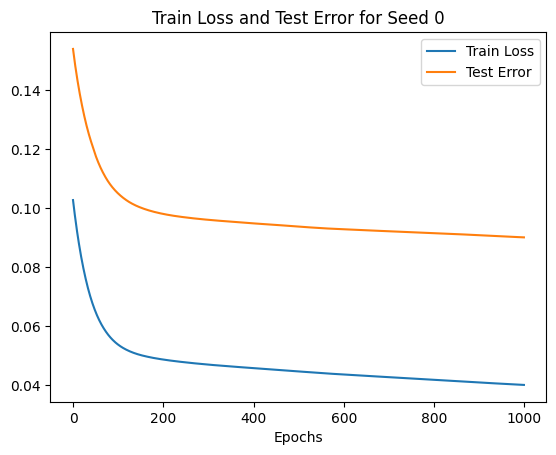

In [35]:
# Define your dataloaders
tensor_X_train = torch.Tensor(x_train_norm)
tensor_Y_train = torch.Tensor(y_train_norm)
tensor_X_test = torch.Tensor(x_test_norm)
tensor_Y_test = torch.Tensor(y_test_norm)

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 10, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 100, shuffle=False)

# instantiate model
abtiters_imputed_net = Net(77)
abtiters_imputed_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(abtiters_imputed_net.parameters(), lr = 1e-4, weight_decay=0.001)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 1000
for i in range(1):
  plot_data, y_pred, y_test = train_model(abtiters_imputed_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

y_test = y_test.numpy()
y_pred = y_pred.numpy()

0.30905342
0.08413241
0.34200227
0.27682388
SignificanceResult(statistic=-0.15, pvalue=0.7000942309691419)


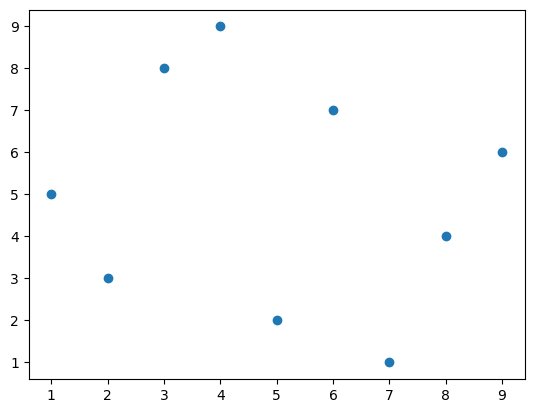

In [36]:
print(np.mean(y_pred))
print(np.std(y_pred))
print(np.mean(y_test))
print(np.std(y_test))

pred_ranks = rankdata(y_pred)
test_ranks = rankdata(y_test)

plt.scatter(test_ranks, pred_ranks)
rank_correlation = scipy.stats.spearmanr(pred_ranks, test_ranks)
print(rank_correlation)

PearsonRResult(statistic=-0.11340793686681769, pvalue=0.7714291019065213)


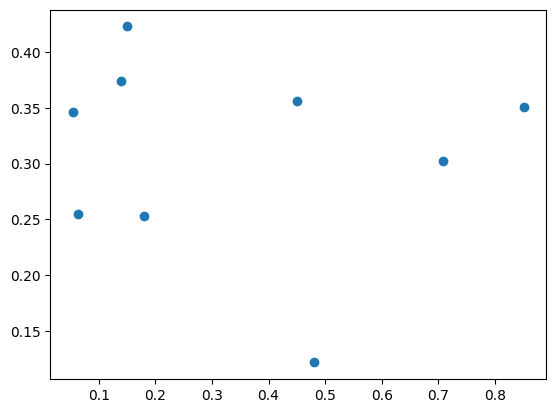

In [37]:
plt.scatter(y_test, y_pred)
correlation = scipy.stats.pearsonr(y_pred.flatten(), y_test.flatten())
print(correlation)

In [65]:
print(pred_abtiter_metadata.columns)

Index(['specimen_id', 'subject_id', 'actual_day_relative_to_boost',
       'planned_day_relative_to_boost', 'specimen_type', 'visit',
       'infancy_vac', 'biological_sex', 'ethnicity', 'race', 'year_of_birth',
       'date_of_boost', 'dataset', 'timepoint'],
      dtype='object')


### Make final predictions:

In [67]:
# load the data

# Cokie's google drive paths:
data_base_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/'
abtiter_normalized_test_path = data_base_path + 'AbtiterNormalizedTestData.tsv'
abtiter_metadata_test_path = data_base_path + 'AbtiterNormalizedTestMetadata.tsv'
cellfreq_normalized_test_path = data_base_path + 'CytofNormalizedTestData.tsv'
cellfreq_metadata_test_path = data_base_path + 'CytofNormalizedTestMetadata.tsv'
cytokine_normalized_test_path = data_base_path + 'CytokineNormalizedTestData.tsv'
cytokine_metadata_test_path = data_base_path + 'CytokineNormalizedTestMetadata.tsv'

pred_abtiter_normalized_data_raw = pd.read_csv(abtiter_normalized_test_path, sep='\t')
pred_abtiter_metadata = pd.read_csv(abtiter_metadata_test_path, sep='\t')
pred_cellfreq_normalized_data_raw = pd.read_csv(cellfreq_normalized_test_path, sep='\t')
pred_cellfreq_metadata = pd.read_csv(cellfreq_metadata_test_path, sep='\t')
pred_cytokine_normalized_data_raw = pd.read_csv(cytokine_normalized_test_path, sep='\t')
pred_cytokine_metadata = pd.read_csv(cytokine_metadata_test_path, sep='\t')

## load data for abtiters
pred_abtiter_metadata_subset = pred_abtiter_metadata[
    ['specimen_id', 'subject_id', 'planned_day_relative_to_boost', 'biological_sex', 'infancy_vac', 'year_of_birth']
    ]
pred_abtiter_data_transposed = pred_abtiter_normalized_data_raw.T
pred_abtiter_data_transposed.index.name = 'specimen_id'
pred_abtiter_data_transposed.reset_index(inplace=True)
pred_abtiter_data_transposed['specimen_id'] = pd.to_numeric(pred_abtiter_data_transposed['specimen_id'])

print("All abtiter data points (input and output), should be 180 long: ", pred_abtiter_data_transposed.shape)

## load data for cell frequency
pred_cellfreq_metadata_subset = pred_cellfreq_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
pred_cellfreq_data_transposed = pred_cellfreq_normalized_data_raw.T
pred_cellfreq_data_transposed.index.name = 'specimen_id'
pred_cellfreq_data_transposed.reset_index(inplace=True)
pred_cellfreq_data_transposed['specimen_id'] = pd.to_numeric(pred_cellfreq_data_transposed['specimen_id'])

print("All cell freq data points (input and output), should be 62 long: ", pred_cellfreq_data_transposed.shape)

## load data for cytokine concentrations
pred_cytokine_metadata_subset = pred_cytokine_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
pred_cytokine_data_transposed = pred_cytokine_normalized_data_raw.T
pred_cytokine_data_transposed.index.name = 'specimen_id'
pred_cytokine_data_transposed.reset_index(inplace=True)
pred_cytokine_data_transposed['specimen_id'] = pd.to_numeric(pred_cytokine_data_transposed['specimen_id'])

print("All cytokine data points (input and output), should be 56 long: ", pred_cytokine_data_transposed.shape)

All abtiter data points (input and output), should be 180 long:  (62, 28)
All cell freq data points (input and output), should be 62 long:  (62, 23)
All cytokine data points (input and output), should be 56 long:  (56, 31)


In [71]:
# combine the data types, then impute any values that are missing for
# cell freq, cytokines, abtiters
pred_all_titerPred_data = pd.merge(pred_abtiter_data_transposed, pred_cellfreq_data_transposed, how='left', on='specimen_id')
pred_all_titerPred_data = pd.merge(pred_all_titerPred_data, pred_cytokine_data_transposed, how='left', on='specimen_id')
pred_all_titerPred_data['specimen_id'] = pd.to_numeric(pred_abtiter_data_transposed['specimen_id'])
pred_all_titerPred_merged_metadata = pred_all_titerPred_data.merge(pred_abtiter_metadata_subset, how='left', on='specimen_id')
pred_all_titerPred_time_subset = pred_all_titerPred_merged_metadata[pred_all_titerPred_merged_metadata['planned_day_relative_to_boost'].isin([0])]

# split metadata off in the same order as the prediction input data
pred_metadata = pred_all_titerPred_time_subset[['specimen_id', 'subject_id', 'year_of_birth', 'biological_sex', 'infancy_vac']]
print(
    "metadata and input data still in same order: ",
    pred_all_titerPred_time_subset['specimen_id'].tolist() == pred_metadata['specimen_id'].tolist()
    )

# make sure features match training data and is in same order
pred_x = pred_all_titerPred_time_subset.drop(
        [
        'planned_day_relative_to_boost', 'subject_id', 'specimen_id', 'ASCs (Plasmablasts)', 'CD3CD19',
        'year_of_birth', 'biological_sex', 'infancy_vac'
        ], axis=1
    )
pred_x = pred_x[data_x.columns.tolist()]

print("All input (x) data points, should be 90 long: ", pred_x.shape)

# impute missing data
imputer = SimpleImputer(strategy='median')
x_pred_imputed = imputer.fit_transform(pred_x)

# normalize data across types, by input and output
scaler = MinMaxScaler()
scaler.fit(x_pred_imputed)
x_pred_norm = scaler.transform(x_pred_imputed)

metadata and input data still in same order:  True
All input (x) data points, should be 90 long:  (21, 77)


In [72]:
tensor_X_pred = torch.Tensor(x_pred_norm)
pred_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
pred_loader = DataLoader(dataset=train_dataset, batch_size = 100, shuffle=False)

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 1000

yhat = []

abtiters_imputed_net.eval()
with torch.no_grad():
    yhat = abtiters_imputed_net(x_pred_norm)

In [73]:
print(np.mean(yhat.numpy()))
print(np.std(yhat.numpy()))

#print(yhat.numpy())
pred_ranks = 22 - rankdata(yhat)
print(pred_ranks)

0.13383064
0.15995082
[21.  4.  3.  7.  1.  6.  8. 17. 20. 19. 13. 10. 18.  5.  9. 12. 11.  2.
 15. 16. 14.]


In [100]:
# format submission file
submission = pred_metadata.drop(['specimen_id'], axis=1)
empty_subs = [
    'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na', 'Na'
    ]
submission.insert(submission.shape[1], '1.1) IgG-PT-D14-titer-Rank', pred_ranks)
submission.insert(submission.shape[1], '1.2) IgG-PT-D14-FC-Rank', empty_subs)
submission.insert(submission.shape[1], '2.1) Monocytes-D1-Rank', empty_subs)
submission.insert(submission.shape[1], '2.2) Monocytes-D1-FC-Rank', empty_subs)
submission.insert(submission.shape[1], '3.1) CCL3-D3-Rank', empty_subs)
submission.insert(submission.shape[1], '3.2) CCL3-D3-FC-Rank', empty_subs)

submission.columns = [
    'Subject ID', 'Age', 'Biological Sex at Birth', 'Vaccine Priming Status',
    '1.1) IgG-PT-D14-titer-Rank', '1.2) IgG-PT-D14-FC-Rank', '2.1) Monocytes-D1-Rank', '2.2) Monocytes-D1-FC-Rank',
    '3.1) CCL3-D3-Rank', '3.2) CCL3-D3-FC-Rank'
]

# make sure submission is sorted by subject id
submission = submission.sort_values('Subject ID')

# change data of birth to age
submission['Age'] = pd.to_datetime(submission['Age'])  # Convert the column to datetime format

# Calculate age based on the year of birth and the current year (2023)
current_year = datetime.now().year
submission['Age'] = current_year - submission['Age'].dt.year

# write submission to file
submission.to_csv('2ndChallengeSubmission_CokieParker.tsv', sep='\t', index=False)

In [99]:
print(submission)

    Subject ID  Age Biological Sex at Birth Vaccine Priming Status  \
22          97   38                    Male                     wP   
13          98   31                  Female                     wP   
56          99   25                  Female                     aP   
27         100   23                  Female                     aP   
61         101   21                    Male                     aP   
33         102   21                    Male                     aP   
2          103   30                  Female                     wP   
42         104   35                  Female                     wP   
16         105   30                  Female                     wP   
39         106   28                  Female                     aP   
47         107   26                  Female                     aP   
48         108   29                  Female                     wP   
57         109   35                  Female                     wP   
24         110   27 